In [2]:
import argparse
import torch
import torch.nn as nn
import dgl
from dgl.dataloading import MultiLayerFullNeighborSampler, as_edge_prediction_sampler
from dgl.dataloading.negative_sampler import Uniform
import pandas as pd
import numpy as np
import itertools
import tqdm
import dgl.function as fn
import torch
from dgl import save_graphs, load_graphs
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv, HeteroGraphConv
import tqdm
import torch as th
import dgl.nn as dglnn
import gc
import warnings
warnings.filterwarnings('ignore')

gc.collect()

parser = argparse.ArgumentParser(description='Link prediction')
parser.add_argument('-f', '--file_path', default='data/graph_data.bin', type=str, help='dgl图文件路径')
parser.add_argument('-d', '--device', default=None, type=str, help='设备, cpu或cuda')
parser.add_argument('-e', '--epoch', default=20, type=int, help='运行回合数')
args = parser.parse_args()

''' gpu训练暂时没跑通
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = device if args.device == None else args.device
'''
hetero_graph = load_graphs('../data/model/graph_data.bin')[0][0]

# print(f'device: {device}')
print('图结构: \n', hetero_graph)

class RelGraphConvLayer(nn.Module):

    def __init__(self,
                 in_feat,
                 out_feat,
                 rel_names,
                 num_bases,
                 *,
                 weight=True,
                 bias=True,
                 activation=None,
                 self_loop=False,
                 dropout=0.0):
        super(RelGraphConvLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop

        # 这个地方只是起到计算的作用, 不保存数据
        self.conv = HeteroGraphConv({
            # graph conv 里面有模型参数weight,如果外边不传进去的话,里面新建
            # 相当于模型加了一层全链接, 对每一种类型的边计算卷积
            rel: GraphConv(in_feat, out_feat, norm='right',
                           weight=False, bias=False)
            for rel in rel_names
        })

        self.use_weight = weight
        self.use_basis = num_bases < len(self.rel_names) and weight
        if self.use_weight:
            if self.use_basis:
                self.basis = dglnn.WeightBasis(
                    (in_feat, out_feat), num_bases, len(self.rel_names))
            else:
                # 每个关系,又一个weight,全连接层
                self.weight = nn.Parameter(
                    th.Tensor(len(self.rel_names), in_feat, out_feat))
                nn.init.xavier_uniform_(
                    self.weight, gain=nn.init.calculate_gain('relu'))

        # bias
        if bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)

        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                    gain=nn.init.calculate_gain('relu'))

        self.dropout = nn.Dropout(dropout)

    def forward(self, g, inputs):

        g = g.local_var()
        if self.use_weight:
            weight = self.basis() if self.use_basis else self.weight
            # 这每个关系对应一个权重矩阵对应输入维度和输出维度
            wdict = {self.rel_names[i]: {'weight': w.squeeze(0)}
                     for i, w in enumerate(th.split(weight, 1, dim=0))}
        else:
            wdict = {}

        if g.is_block:
            inputs_src = inputs
            inputs_dst = {k: v[:g.number_of_dst_nodes(
                k)] for k, v in inputs.items()}
        else:
            inputs_src = inputs_dst = inputs

        # 多类型的边结点卷积完成后的输出
        # 输入的是blocks 和 embeding
        # inputs = {key: value.to(device) for key, value in inputs.items()}
        hs = self.conv(g, inputs, mod_kwargs=wdict)

        def _apply(ntype, h):
            if self.self_loop:
                h = h + th.matmul(inputs_dst[ntype], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.activation:
                h = self.activation(h)
            return self.dropout(h)

        return {ntype: _apply(ntype, h) for ntype, h in hs.items()}


class RelGraphEmbed(nn.Module):
    r"""Embedding layer for featureless heterograph."""

    def __init__(self,
                 g,
                 embed_size,
                 embed_name='embed',
                 activation=None,
                 dropout=0.0):
        super(RelGraphEmbed, self).__init__()
        self.g = g
        self.embed_name = embed_name
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        # create weight embeddings for each node for each relation
        self.embeds = nn.ParameterDict()
        for ntype in g.ntypes:
            if ntype == 'customer':
                embed = g.ndata['x'][ntype]
            self.embeds[ntype] = embed
            
    def forward(self, block=None):

        return self.embeds


class EntityClassify(nn.Module):
    def __init__(self,
                 g,
                 h_dim, out_dim,
                 num_bases=-1,
                 num_hidden_layers=1,
                 dropout=0,
                 use_self_loop=False):
        super(EntityClassify, self).__init__()
        self.g = g
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.rel_names = list(set(g.etypes))
        self.rel_names.sort()
        if num_bases < 0 or num_bases > len(self.rel_names):
            self.num_bases = len(self.rel_names)
        else:
            self.num_bases = num_bases
        self.num_hidden_layers = num_hidden_layers
        self.dropout = dropout
        self.use_self_loop = use_self_loop

        self.embed_layer = RelGraphEmbed(g, self.h_dim)
        self.layers = nn.ModuleList()
        # i2h
        self.layers.append(RelGraphConvLayer(
            self.h_dim, self.h_dim, self.rel_names,
            self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
            dropout=self.dropout, weight=False))

        # h2h , 这里不添加隐层,只用2层卷积
        # for i in range(self.num_hidden_layers):
        #    self.layers.append(RelGraphConvLayer(
        #        self.h_dim, self.h_dim, self.rel_names,
        #        self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
        #        dropout=self.dropout))
        # h2o

        self.layers.append(RelGraphConvLayer(
            self.h_dim, self.out_dim, self.rel_names,
            self.num_bases, activation=None,
            self_loop=self.use_self_loop))

    # 输入 blocks,embeding
    def forward(self, h=None, blocks=None):
        if h is None:
            # full graph training
            h = self.embed_layer()
        if blocks is None:
            # full graph training
            for layer in self.layers:
                h = layer(self.g, h)
        else:
            # minibatch training
            # 输入 blocks,embeding
            for layer, block in zip(self.layers, blocks):
                h = layer(block, h)
        return h
    
    def inference(self, g, batch_size, device="cpu", num_workers=0, x=None):

        if x is None:
            x = self.embed_layer()

        for l, layer in enumerate(self.layers):
            y = {
                k: th.zeros(
                    g.number_of_nodes(k),
                    self.h_dim if l != len(self.layers) - 1 else self.out_dim)
                for k in g.ntypes
                }
            
            sampler = dgl.dataloading.MultiLayerFullNeighborSampler(1)
            dataloader = dgl.dataloading.DataLoader(
                g,
                {k: th.arange(g.number_of_nodes(k)) for k in g.ntypes},
                sampler,
                batch_size=batch_size,
                shuffle=True,
                drop_last=False,
                num_workers=num_workers)
            
            for input_nodes, output_nodes, blocks in tqdm.tqdm(dataloader):
                # print(input_nodes)
                block = blocks[0]  # .to(device)
                h = {k: x[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
                h = layer(block, h)
                for k in h.keys():
                    y[k][output_nodes[k]] = h[k].cpu()
            x = y
        return y


# 根据节点类型和节点ID抽取embeding 参与模型训练更新
def extract_embed(node_embed, input_nodes):
    emb = {}
    for ntype, nid in input_nodes.items():
        nid = input_nodes[ntype]
        emb[ntype] = node_embed[ntype][nid.to('cpu')]
    return emb

# Define a Heterograph Conv model


class Model(nn.Module):

    def __init__(self, graph, hidden_feat_dim, out_feat_dim):
        super().__init__()
        self.rgcn = EntityClassify(graph,
                                   hidden_feat_dim,
                                   out_feat_dim)
        self.pred = HeteroDotProductPredictor()

    def forward(self, h, pos_g, neg_g, blocks, etype):
        h = self.rgcn(h, blocks)  # h 是客户的维度12的特征矩阵，输出是转换后的嵌入
        return self.pred(pos_g, h, etype), self.pred(neg_g, h, etype)
    
    
class MarginLoss(nn.Module):

    def forward(self, pos_score, neg_score):
        # 求损失的平均值 , view 改变tensor 的形状
        # 1 - pos_score + neg_score, 应该是 -pos 符号越大变成越小  +neg_score 越小越好
        return (1 - pos_score + neg_score.view(pos_score.shape[0], -1)).clamp(min=0).mean()


class HeteroDotProductPredictor(nn.Module):

    def forward(self, graph, h, etype):
        # 在计算之外更新h, 保存为全局可用
        # h contains the node representations for each edge type computed from node_clf_hetero.py
        with graph.local_scope():
            graph.ndata['h'] = h  # assigns 'h' of all node types in one shot
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'), etype=etype)
            return graph.edges[etype].data['score']

图结构: 
 Graph(num_nodes={'customer': 161086, 'product': 2708},
      num_edges={('customer', 'order', 'product'): 11892915, ('product', 'class', 'product'): 1796620, ('product', 'rev_class', 'product'): 1796620, ('product', 'rev_order', 'customer'): 11892915},
      metagraph=[('customer', 'product', 'order'), ('product', 'product', 'class'), ('product', 'product', 'rev_class'), ('product', 'customer', 'rev_order')])


<Axes: >

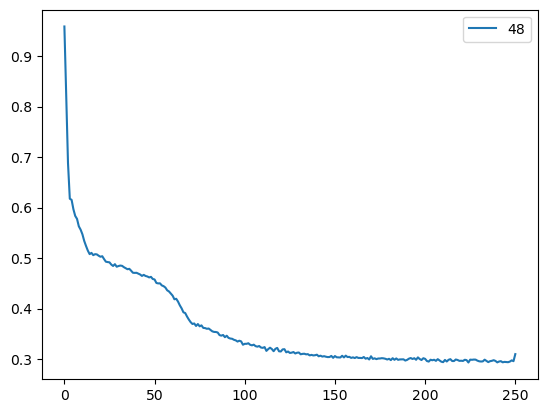

In [13]:
loss_table = pd.read_csv('../data/test/result_2.csv')
loss_table.plot()

In [14]:
embed_layer = torch.load(f'../ckpt/test/model_2_embed_layer_48.pt')
all_node_embed = embed_layer()

batch_size = hetero_graph['order'].num_edges() // 250
hidden_feat_dim = out_feat_dim = 12

model = Model(hetero_graph, hidden_feat_dim, out_feat_dim)
model.load_state_dict(torch.load('../ckpt/test/model_2_params_48.pt'))

# 模型预估的结果, 最后应该使用 inference, 这里得到的是logit
with torch.no_grad():
    inference_out = model.rgcn.inference(hetero_graph, batch_size, 'cpu', 0, all_node_embed)
print('商品嵌入矩阵大小: ', inference_out["product"].shape)
print('客户嵌入矩阵大小: ', inference_out["customer"].shape)
print(inference_out['customer'][0])
print(inference_out['product'][0])

100%|██████████| 4/4 [00:00<00:00,  9.43it/s]

商品嵌入矩阵大小:  torch.Size([2708, 12])
客户嵌入矩阵大小:  torch.Size([161086, 12])
tensor([-1.5808, -2.1750,  0.4235,  1.4268, -2.0509, -0.4789,  1.9850, -1.6551,
        -1.4159, -1.6916, -1.0065, -0.2843])
tensor([ 0.9444,  0.8982,  0.2033, -0.7202,  0.0337, -2.1232,  5.0751,  0.0437,
        -0.5339, -0.0967,  0.7251,  4.3471])


In [15]:
predict = (inference_out["customer"] @ inference_out["product"].T).detach().numpy()  # 购买意愿值

In [16]:
target = predict.argmax(axis=1)

In [34]:
pd.Series(target).value_counts().index

Index([ 256, 1059,  178, 1133,  886,   35,  858, 1830,  356,  322, 1266,  528,
        723, 1329,   14,  695, 1341,  962,  487, 1373,  388, 2056],
      dtype='int64')

In [31]:
cus_map = torch.load('../data/model/commodity_map.pt')
commodity = pd.read_csv('../data/commodity.csv')

In [32]:
cus_map[256]

6970878583757869229

In [33]:
commodity[commodity['商品编码']==cus_map[256]]

,id,商品编码,商品名称,品牌名称,规格,单位,生产厂家,批准文号,库存数量,疾病分类统一,商品类别,医保类型,工业采购价,客户采购价格,建议零售价,工业毛利额,客户毛利额,客户毛利率,上架日期,最后一次采购日期
307,973b7425-f39e-4205-8f32-0ef7ad2c61d6,6970878583757869229,舒筋****血片,蜀汉本草,0.3g*36片,盒,好大****有限公司,国药准字Z14020936,120802,风湿骨病,处方用药.中成药,甲类,1.65,2.68,12.0,1.03,9.32,0.776667,2021-04-07,2024-01-04


In [39]:
com_tabel = pd.DataFrame()
for index in pd.Series(target).value_counts().index:
    com_tabel = pd.concat([com_tabel, commodity[commodity['商品编码']==cus_map[index]]], axis=0)

In [41]:
com_tabel  # 高潜在价值商品

,id,商品编码,商品名称,品牌名称,规格,单位,生产厂家,批准文号,库存数量,疾病分类统一,商品类别,医保类型,工业采购价,客户采购价格,建议零售价,工业毛利额,客户毛利额,客户毛利率,上架日期,最后一次采购日期
307,973b7425-f39e-4205-8f32-0ef7ad2c61d6,6970878583757869229,舒筋****血片,蜀汉本草,0.3g*36片,盒,好大****有限公司,国药准字Z14020936,120802,风湿骨病,处方用药.中成药,甲类,1.6500,2.68,12.0,1.0300,9.32,0.776667,2021-04-07,2024-01-04
1226,57bd248f-506f-46ca-b23e-56fe7a4ae8f7,6970878583023866127,人工****硝唑胶囊,驰铭,0.2g:5mg*24粒,盒,山西****有限公司,国药准字H14022919,187660,五官用药,处方用药.化学药制剂,乙类,2.1000,3.38,12.0,1.2800,8.62,0.718333,2022-04-12,2024-01-18
225,3ef832a1-a7f9-4ddd-adf8-615339e1c901,6970878583019672161,小儿****那敏颗粒,小葫芦宝,13袋,盒,山西****有限公司,国药准字H14022920,234610,儿科用药,化学药制剂.甲类OTC,乙类,1.6900,2.68,10.0,0.9900,7.32,0.732000,2021-12-05,2024-01-18
1320,a56b4c26-d5f8-4af2-a36e-647b111b44de,6970878582294057515,多潘****酮片,驰铭,10mg*30片,盒,山西****有限公司,国药准字H20093772,110443,消化系统,化学药制剂.甲类OTC,甲类,3.7000,5.99,21.8,2.2900,15.81,0.725229,2021-09-06,2024-01-18
1030,6715dc52-5c36-45ac-9539-5202320f232e,6970878583023865864,鸡****眼贴,蜀汉本草,6贴,盒,江西****有限公司,赣卫消证字（2018）第C020号,25868,日化护理,I类医疗器械,非医保,1.6700,2.69,10.0,1.0200,7.31,0.731000,2021-08-30,2024-01-15
48,e39c995f-2da3-4ebe-9542-8c13f6684b56,6970878582294057428,脑心****服液,蜀汉本草,10ml*13支,盒,湖北****有限公司,国药准字Z42020097,195829,补益用药,甲类OTC.中成药,乙类,5.2000,8.49,28.0,3.2900,19.51,0.696786,2020-08-19,2024-01-04
997,436567d0-5c0d-4ca7-828d-3048157bad56,7018480927571574784,复方****银花颗粒,蜀汉本草,10g*10袋,盒,黑龙****滨分公司,国药准字Z23021107,424665,清热解毒,甲类OTC.中成药,非医保,5.5000,8.68,29.8,3.1800,21.12,0.708725,2023-01-16,2024-01-22
2291,98b13e98-4ce5-4750-9961-7c2e6f10136f,6970878583757869359,陈****皮,京鸿阁,丝/500g,包,四川****责任公司,/,560,中药饮片,中药饮片,医保,8.5000,11.90,23.8,3.4000,11.90,0.500000,2022-09-24,2024-01-03
419,4404ac5f-3a43-4c26-82fb-490939bc3356,6970878583019671948,龙胆****肝丸,蜀汉本草,6g*8袋,盒,河南****限公司）,国药准字Z41020022,66803,肝胆用药,甲类OTC.中成药,甲类,3.6000,5.79,19.8,2.1900,14.01,0.707576,2021-04-14,2024-01-19
383,11552011-efb5-4a2e-a5ba-4c8c6cbf9a46,6970878582294057502,逍****遥丸,蜀汉本草,168丸*2瓶,盒,河南****有限公司,国药准字41020026,39397,妇科用药,甲类OTC.中成药,甲类,7.2000,11.38,38.0,4.1800,26.62,0.700526,2021-05-23,2024-01-15
